# San Francisco Housing-Market Analysis

In this notebook, we perform an analysis of the San Francisco housing market in an effort to allow potential real-estate investors to choose rental investment properties.

## Preliminaries

### Python Imports

In [1]:
# Python imports
import os
import numpy as np
import pandas as pd
import plotly.express as px
import panel as pn
pn.extension('plotly')

# This import needs to happen *after* the `panel`/`plotly` import (see above)
import hvplot.pandas

# Other stuff
from pathlib import Path
from dotenv import load_dotenv
from bokeh.models.formatters import NumeralTickFormatter
from holoviews.plotting import DEFAULT_CYCLE
from bokeh.palettes import Category10  # another color cycler

### Define Common Plot Parameters

In [3]:
# Here are some `hvplot` defaults
hvplot_width_default = 700  # px
hvplot_height_default = 300
hvplot_line_width_default = 2
hvplot_marker_size_squared_default = 30

# Here are our custom defaults
hvplot_width = 1000
hvplot_height = int(hvplot_height_default * (hvplot_width / hvplot_width_default))
hvplot_fontscale = 0.5 * ((hvplot_width / hvplot_width_default) + (hvplot_width / hvplot_width_default))
hvplot_line_width = hvplot_line_width_default * hvplot_fontscale
hvplot_marker_size_squared = 2 * hvplot_fontscale**2 * hvplot_marker_size_squared_default
default_color_cycle = Category10[10]

### Load Your MapBox API Key

In [4]:
# Load your MapBox API key
load_dotenv('/path/to/your/python-dotenv.txt')
mapbox_api_key = os.getenv('MAPBOX_API_KEY')  # change to your MapBox API key!

---

## Load Raw Data

In [5]:
# Read the raw census data into a `pandas/DataFrame`
file_path = Path('./data/sfo_neighborhoods_census_data.csv')
sfo_data_raw = pd.read_csv(file_path, index_col='year')

# Create a copy of the raw data (for safe keeping) and rename columns
sfo_data = sfo_data_raw.copy()
sfo_data.columns = ['neighborhood', 'sale_price_ft2', 'housing_units', 'gross_rent_mo']
sfo_data

neighborhood  sale_price_ft2  housing_units  gross_rent_mo
year                                                                      
2010            Alamo Square      291.182945         372560           1239
2010              Anza Vista      267.932583         372560           1239
2010                 Bayview      170.098665         372560           1239
2010        Buena Vista Park      347.394919         372560           1239
2010        Central Richmond      319.027623         372560           1239
...                      ...             ...            ...            ...
2016          Telegraph Hill      903.049771         384242           4390
2016              Twin Peaks      970.085470         384242           4390
2016  Van Ness/ Civic Center      552.602567         384242           4390
2016       Visitacion Valley      328.319007         384242           4390
2016           Westwood Park      631.195426         384242           4390

[397 rows x 4 columns]

---

## Housing Units by Year

In this section, we calculate the average number of housing units per year across SFO neighborhoods and visualize the results as a bar chart.

In [6]:
# Calculate the mean number of housing units per year
sfo_data_by_year = sfo_data.copy().groupby('year').mean()
sfo_housing_units_by_year = sfo_data_by_year['housing_units']

# Calculate limits for y-axis
ymin = sfo_housing_units_by_year.min()
ymax = sfo_housing_units_by_year.max()
yavg = 0.5 * (ymax + ymin)
dy = 0.5 * (ymax - ymin)

# Plot the results
hvplot_sfo_housing_units_by_year = sfo_housing_units_by_year.hvplot.bar(
    title=f"Number of Housing Units vs. Time",
    ylabel='Housing Units',
    xlabel='Year',
    ylim=(yavg - 1.1*dy, yavg + 1.1*dy),
    yformatter=NumeralTickFormatter(),
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    grid=True,
)
pn_sfo_housing_units_by_year = pn.Column(
    '# SFO Housing Market: Yearly Trends',
    hvplot_sfo_housing_units_by_year
)
#pn_sfo_housing_units_by_year.save('./images/sfo-housing-units-by-year.png')
pn_sfo_housing_units_by_year

Column
    [0] Markdown(str)
    [1] HoloViews(Bars)

--- 

## Average Housing Costs Per Year

In this section, we calculate the average monthly rent and the average price per square foot for each year and plot the results.  The thinking is that an investor may wish to better understand the sales price of the rental property over time.  For example, an investor probably wants to know if \[s\]he should expect an increase or decrease in the property value over time in order to determine if the property should be bought or when the property should be sold.

In [7]:
# Define common plot parameters
hvplot_kwargs = dict(
    xlabel='Year',
    width=int(0.5 * hvplot_width),
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    line_width=hvplot_line_width,
    grid=True,
    legend=False,
)

# Plot average sale price per square foot vs. time
sfo_sale_price_ft2_by_year = sfo_data_by_year['sale_price_ft2']
color = Category10[3][1]
hvplot_sfo_sale_price_ft2_by_year = sfo_sale_price_ft2_by_year.hvplot.line(
    title='Sale Price per Square Foot vs. Time',
    ylabel='$USD / ft²',
    yformatter=NumeralTickFormatter(format='$0[.]00'),
    color=color,
    **hvplot_kwargs
) * sfo_data_by_year['sale_price_ft2'].hvplot.scatter(
    s=hvplot_marker_size_squared,
    color=color,
    **hvplot_kwargs
)

# Plot gross rent per month vs. time
sfo_gross_rent_mo_by_year = sfo_data_by_year['gross_rent_mo']
color = Category10[3][2]
hvplot_sfo_gross_rent_mo_by_year = sfo_gross_rent_mo_by_year.hvplot.line(
    title='Gross Rent per Month vs. Time',
    ylabel='$USD / mo',
    yformatter=NumeralTickFormatter(format='$0[.]00'),
    color=color,
    **hvplot_kwargs
) * sfo_data_by_year['gross_rent_mo'].hvplot.scatter(
    s=hvplot_marker_size_squared,
    color=color,
    **hvplot_kwargs
)

# Combine plots into a single panel
pn_sfo_other_data_by_year = pn.Row(hvplot_sfo_sale_price_ft2_by_year, hvplot_sfo_gross_rent_mo_by_year)
#pn_sfo_other_data_by_year.save('./images/sfo-other-data-by-year.png')
pn_sfo_other_data_by_year

Row
    [0] HoloViews(Overlay)
    [1] HoloViews(Overlay)

### Q: How to Include Error Bars?

In [8]:
# Q: Can we add error bars to the above plots?  A: Yes, but only to the
# `gross_rent_mo` plot, since the stdevs of the other data are zero!
sfo_data_by_year_avg = sfo_data.groupby('year').mean()
sfo_data_by_year_std = sfo_data.groupby('year').std()

# This temporary dataframe shows the standard deviations of the data are zero
# except for the `sale_price_ft2`
df_ = pd.concat([sfo_data_by_year_avg, sfo_data_by_year_std], axis=1, join='inner')
df_.columns = pd.MultiIndex.from_product([['MEAN', 'STDEV'], sfo_data_by_year_avg.columns.tolist()])
df_

MEAN                                      STDEV                \
     sale_price_ft2 housing_units gross_rent_mo sale_price_ft2 housing_units   
year                                                                           
2010     369.344353      372560.0        1239.0     155.391162           0.0   
2011     341.903429      374507.0        1530.0     103.299359           0.0   
2012     399.389968      376454.0        2324.0     113.774342           0.0   
2013     483.600304      378401.0        2971.0     187.099909           0.0   
2014     556.277273      380348.0        3528.0     202.963037           0.0   
2015     632.540352      382295.0        3739.0     301.848901           0.0   
2016     697.643709      384242.0        4390.0     321.643184           0.0   

                    
     gross_rent_mo  
year                
2010           0.0  
2011           0.0  
2012           0.0  
2013           0.0  
2014           0.0  
2015           0.0  
2016           0.0

#### Better yet, make a "violin plot"

In [9]:
# Create a "violin plot" out of the `sale_price_ft2`, since these data are the
# only data for which the stdev is not zero
df_ = sfo_data.copy()
df_['year'] = df_.index
df_.index = range(df_.index.size)
hvplot_sfo_sale_price_ft2_by_year_violin = df_.hvplot.violin(
    y='sale_price_ft2',
    by='year',
    color='year',
    cmap='jet',
    title='Sale Price per Square Foot vs. Time',
    xlabel='Year',
    ylabel='$USD / ft²',
    yformatter=NumeralTickFormatter(format='$0,0'),
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    grid=True,
    ylim=(0, 1600),
)
pn_sfo_sale_price_ft2_by_year_violin = pn.Row(hvplot_sfo_sale_price_ft2_by_year_violin)
#pn_sfo_sale_price_ft2_by_year_violin.save('./images/sfo-sale-price-ft2-by-year-violin.png')
pn_sfo_sale_price_ft2_by_year_violin

Row
    [0] HoloViews(Violin)

--- 

## Average Prices by Neighborhood

In this section, we use `hvplot` to create two interactive visulizations of average prices with a dropdown selector for the neighborhood.  The first visualization is a line plot showing the average price per square foot versus time for each neighborhood.  The second plot is a line plot showing the trend of average monthly rent over time for each neighborhood.  

In [10]:
def average_price_by_neighborhood(neighborhood: str):
    df_tmp = sfo_data.groupby(['neighborhood', 'year']).mean()
    kwargs = dict(
        xlabel='Year',
        yformatter=NumeralTickFormatter(format='$0,0'),
        grid=True,
    )
    return pn.Column(
        df_tmp.loc[neighborhood, 'sale_price_ft2'].hvplot.line(
            title=f"Neighborhood \"{neighborhood}\": Sale Price per Square Foot vs. Time",
            ylabel='$USD / ft²',
            **kwargs
        ),
        df_tmp.loc[neighborhood, 'gross_rent_mo'].hvplot.line(
            title=f"Neighborhood \"{neighborhood}\": Gross Rent per Month vs. Time",
            ylabel='$USD / mo',
            **kwargs
        ),
    )


# Get a list of all neighborhoods (alphabetized)
neighborhoods = sfo_data['neighborhood'].sort_values().unique().tolist()

# Get the plot and the widget
the_widget, the_plot = pn.interact(average_price_by_neighborhood, neighborhood=neighborhoods)

# Display the plot and the widget
pn.Column(pn.WidgetBox(the_widget), the_plot)

Column
    [0] WidgetBox
        [0] Column
            [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
    [1] Row
        [0] Column
            [0] HoloViews(Curve)
            [1] HoloViews(Curve)

In [11]:
def get_neighborhood_plots(neighborhood: str):
    """
    """
    df_ = sfo_data.copy().groupby(['neighborhood', 'year']).mean()

    df_housing_units_ = df_.loc[neighborhood, 'housing_units']
    df_sale_price_ft2_ = df_.loc[neighborhood, 'sale_price_ft2']
    df_gross_rent_mo_ = df_.loc[neighborhood, 'gross_rent_mo']
    
    # Define plot parameters common for all plots in this function
    hvplot_kwargs = dict(
        xlabel='Year',
        width=int(1 * hvplot_width),
        height=int(0.8 * hvplot_height),
        fontscale=hvplot_fontscale,
        grid=True,
    )
    
    ymin = df_housing_units_.min()
    ymax = df_housing_units_.max()
    yavg = 0.5 * (ymax + ymin)
    dy = 0.5 * (ymax - ymin)
    hvplot_housing_units_ = df_housing_units_.hvplot.bar(
        title='Number of Housing Units vs. Time',
        ylabel='Housing Units',
        yformatter=NumeralTickFormatter(),
        ylim=(ymin - 1.1*dy, ymax + 1.1*dy),
        **hvplot_kwargs
    )
    
    color = Category10[3][1]
    hvplot_sale_price_ft2_ = df_sale_price_ft2_.hvplot.line(
        title='Sale Price per Square Foot vs. Time',
        ylabel='$USD / ft²',
        yformatter=NumeralTickFormatter(format='$0,0[.]00'),
        line_width=hvplot_line_width,
        color=color,
        legend=False,
        **hvplot_kwargs
    ) * df_sale_price_ft2_.hvplot.scatter(
        s=hvplot_marker_size_squared,
        color=color,
        legend=False,
        **hvplot_kwargs
    )
    
    color = Category10[3][2]
    hvplot_gross_rent_mo_ = df_gross_rent_mo_.hvplot.line(
        title='Gross Rent per Month vs. Time',
        ylabel='$USD / mo',
        yformatter=NumeralTickFormatter(format='$0,0[.]00'),
        line_width=hvplot_line_width,
        color=color,
        legend=False,
        **hvplot_kwargs
    ) * df_gross_rent_mo_.hvplot.scatter(
        s=hvplot_marker_size_squared,
        color=color,
        legend=False,
        **hvplot_kwargs
    )
    
    return pn.Column(
        hvplot_housing_units_,
        hvplot_sale_price_ft2_,
        hvplot_gross_rent_mo_,
    )


# Get the list of all SFO neightborhoods
sfo_neighborhoods_list = sfo_data['neighborhood'].sort_values().unique().tolist()  # alphabetical

widget, plot = pn.interact(get_neighborhood_plots, neighborhood=sfo_neighborhoods_list)

pn_sfo_housing_data_by_neighborhood = pn.Column(
    '# SFO Housing-Market Data by Neighborhood',
    pn.WidgetBox(widget),
    plot,
)
#pn_sfo_housing_data_by_neighborhood.save('./images/sfo-housing-data-by-neighborhood.png')
pn_sfo_housing_data_by_neighborhood

Column
    [0] Markdown(str)
    [1] WidgetBox
        [0] Column
            [0] Select(name='neighborhood', options=['Alamo Square', ...], value='Alamo Square')
    [2] Row
        [0] Column
            [0] HoloViews(Bars)
            [1] HoloViews(Overlay)
            [2] HoloViews(Overlay)

---

## Bonus Plot: Crossfilter

- The horizontal axis is sales price per square foot, the vertical axis is gross rent per month.
- The data are colored by (`gross_rent_mo` / `sale_price_ft2`), which is a measure of investor profitablity (albeit crude).
- The size of the datapoints are proportional to the number of housing units available.

In [18]:
df_ = sfo_data.groupby('neighborhood').mean()

xlabel = 'sale_price_ft2'
ylabel = 'gross_rent_mo'
clabel = f"{ylabel} / {xlabel}"
slabel = 'housing_units'
slabel_minmax = f"{slabel}_minmax"

df_[clabel] = df_[ylabel] / df_[xlabel]
df_[slabel_minmax] = (df_[slabel] - df_[slabel].min()) / (df_[slabel].max() - df_[slabel].min())

hvplot_crossfilter = df_.hvplot.scatter(
    x=xlabel,
    y=ylabel,
    c=clabel,
    #s=slabel_minmax,
    s=clabel,
    
    scale=int(hvplot_marker_size_squared / 12),
    cmap='RdYlGn',
    alpha=0.5,
    
    title='Average Quantities by Neighborhood',
    xlabel='Sale Price / ft²',
    ylabel='Gross Rent / mo',
    clabel='(Gross Rent / mo)  /  (Sale Price / ft²)',
    hover_cols='neighborhood',  # add `neighborhood` to hover data
    
    xformatter=NumeralTickFormatter(format='$0,0'),
    yformatter=NumeralTickFormatter(format='$0,0'),
    
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    grid=True,
)
pn_crossfilter = pn.Column(
    #'# SFO Housing Market: Crossfilter Plot',
    hvplot_crossfilter,
)
#pn_crossfilter.save('./images/sfo-crossfilter-neighborhood.png')
pn_crossfilter

Column
    [0] HoloViews(Scatter)

---

## Top 10 Most Expensive Neighborhoods

In this section, we calculate the mean sale price per square foot for each neighborhood and sort the resulting values to obtain the top 10 most expensive neighborhoods on average.  The results are plotted as a bar chart.

In [21]:
# Calculate average quantities grouped by neighborhood
sfo_data_by_neighborhood_avg = sfo_data.groupby('neighborhood').mean()
sfo_data_by_neighborhood_avg

sale_price_ft2  housing_units  gross_rent_mo
neighborhood                                                    
Alamo Square            366.020712      378401.00    2817.285714
Anza Vista              373.382198      379050.00    3031.833333
Bayview                 204.588623      376454.00    2318.400000
Bayview Heights         590.792839      382295.00    3739.000000
Bernal Heights          576.746488      379374.50    3080.333333
...                            ...            ...            ...
West Portal             498.488485      376940.75    2515.500000
Western Addition        307.562201      377427.50    2555.166667
Westwood Highlands      533.703935      376454.00    2250.500000
Westwood Park           687.087575      382295.00    3959.000000
Yerba Buena             576.709848      377427.50    2555.166667

[73 rows x 3 columns]

## Top 10 Expensive Neighborhoods

In [ ]:
# Get the Top 10 most expensive neighborhoods in San Francisco as measured by average sale price per square foot
sfo_expensive_neighborhoods_list = sfo_data_by_neighborhood_avg['sale_price_ft2'].sort_values(ascending=False)[:10].index.tolist()
sfo_expensive_neighborhoods_list

---

## Crossfilter Plot

In [ ]:
sfo_data.groupby(['neighborhood', 'year']).mean()

## Top 10 Expensive Neighborhoods

In [19]:
from typing import List


def get_expensive_neighborhood_list(n: int = 10) -> List[str]:
    """
    Helper function to get a list of the most expensive neighborhood names as
    measured by sales price per square foot.
    """
    df_ = sfo_data.copy().groupby('neighborhood').mean()['sale_price_ft2']
    return df_.sort_values(ascending=False)[:n].index.tolist()


# Plot the results as a bar chart
sfo_expensive_neighborhoods_list = get_expensive_neighborhood_list()
df_ = sfo_data_by_neighborhood_avg.loc[sfo_expensive_neighborhoods_list]['sale_price_ft2']

# Plot the results as a bar chart
ymin = df_.min()
ymax = df_.max()
yavg = 0.5 * (ymax + ymin)
dy = 0.5 * (ymax - ymin)

hvplot_sfo_expensive_neighborhoods = df_.hvplot.bar(
    title='Top 10 Most Expensive Neighborhoods (by Average Sale Price per Square Foot)',
    xlabel='Neighborhood',
    ylabel='$USD / ft²',
    rot=45,
    ylim=((yavg - 1.1*dy), (yavg + 1.1*dy)),
    yformatter=NumeralTickFormatter(format='$0,0'),
    width=hvplot_width,
    height=hvplot_height,
    fontscale=hvplot_fontscale,
    grid=True,
)
pn_sfo_expensive_neighborhoods = pn.panel(hvplot_sfo_expensive_neighborhoods)
#pn_sfo_expensive_neighborhoods.save('./images/sfo-expensive-neighborhoods.png')
pn_sfo_expensive_neighborhoods

HoloViews(Bars)

In [20]:
def plot_expensive_neighborhood_by_year(neighborhood: str):
    """
    """
    df_ = sfo_data.drop(columns='housing_units').groupby(['neighborhood', 'year']).mean().loc[neighborhood]
    return df_.hvplot.bar(
        title=f"Neighborhood: {neighborhood}",
        ylabel='Cost (USD)',
        xlabel='Year',
        rot=90,
        yformatter=NumeralTickFormatter(format='$0,0'),
        width=hvplot_width,
        height=hvplot_height,
        fontscale=hvplot_fontscale,
        grid=True,
    )


widget, plot = pn.interact(plot_expensive_neighborhood_by_year, neighborhood=sfo_expensive_neighborhoods_list)
pn_expensive_neighborhood_by_year = pn.Column(pn.WidgetBox(widget), plot)
#pn_expensive_neighborhood_by_year.save('./images/sfo-expensive-neighborhood-by-year.png')
pn_expensive_neighborhood_by_year

Column
    [0] WidgetBox
        [0] Column
            [0] Select(name='neighborhood', options=['Union Square District', ...], value='Union Square District')
    [1] Row
        [0] HoloViews(Bars, name='interactive06952')

---

## MapBox Visualization

### Load Your MapBox API Key

In [22]:
# Load your MapBox API key
load_dotenv('/path/to/your/python-dotenv.txt')
mapbox_api_key = os.getenv('MAPBOX_API_KEY')  # change to your MapBox API key!

### Create Housing Dataframe with Latitude/Longitude Data

In [23]:
sfo_neighborhoods_mapbox = pd.concat(
    [
        sfo_data.groupby('neighborhood').mean(),
        pd.read_csv('./data/sfo_neighborhood_coordinates.csv').groupby('Neighborhood').mean(),
    ],
    axis=1,
    join='inner',
)
sfo_neighborhoods_mapbox = sfo_neighborhoods_mapbox.rename(columns={'Lat': 'lat', 'Lon': 'lon'})
sfo_neighborhoods_mapbox['neighborhood'] = sfo_neighborhoods_mapbox.index.values
sfo_neighborhoods_mapbox

sale_price_ft2  housing_units  gross_rent_mo        lat  \
Alamo Square            366.020712      378401.00    2817.285714  37.791012   
Anza Vista              373.382198      379050.00    3031.833333  37.779598   
Bayview                 204.588623      376454.00    2318.400000  37.734670   
Bayview Heights         590.792839      382295.00    3739.000000  37.728740   
Buena Vista Park        452.680591      378076.50    2698.833333  37.768160   
...                            ...            ...            ...        ...   
West Portal             498.488485      376940.75    2515.500000  37.740260   
Western Addition        307.562201      377427.50    2555.166667  37.792980   
Westwood Highlands      533.703935      376454.00    2250.500000  37.734700   
Westwood Park           687.087575      382295.00    3959.000000  37.734150   
Yerba Buena             576.709848      377427.50    2555.166667  37.792980   

                           lon        neighborhood  
Alamo Square       -122.402100        Alamo Square  
Anza Vista         -122.443451          Anza Vista  
Bayview            -122.401060             Bayview  
Bayview Heights    -122.410980     Bayview Heights  
Buena Vista Park   -122.439330    Buena Vista Park  
...                        ...                 ...  
West Portal        -122.463880         West Portal  
Western Addition   -122.435790    Western Addition  
Westwood Highlands -122.456854  Westwood Highlands  
Westwood Park      -122.457000       Westwood Park  
Yerba Buena        -122.396360         Yerba Buena  

[69 rows x 6 columns]

### Generate MapBox Visualization

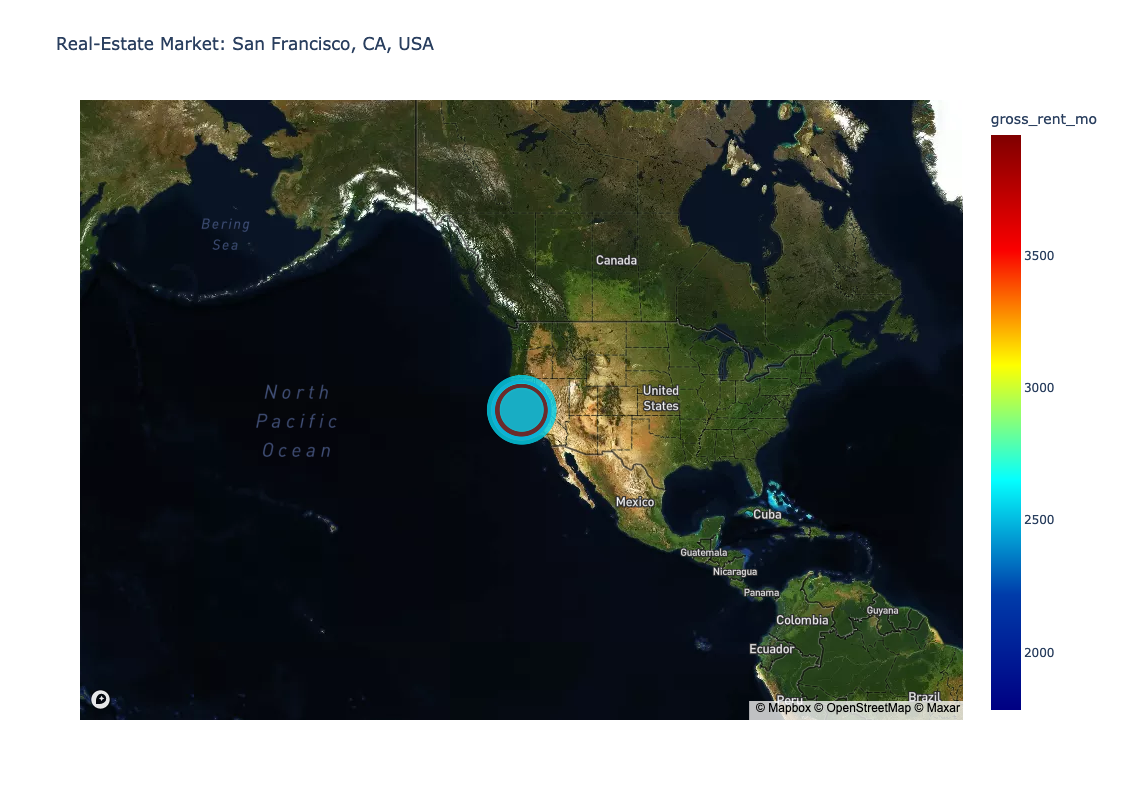

In [24]:
mapbox_plot = px.scatter_mapbox(
    sfo_neighborhoods_mapbox,
    lat='lat',
    lon='lon',
    
    color='gross_rent_mo',
    color_continuous_scale='jet',
    
    size=sfo_neighborhoods_mapbox['sale_price_ft2'].pow(2),
    size_max=50,
    
    hover_name='neighborhood',
    title='Real-Estate Market: San Francisco, CA, USA',    
    width=hvplot_width,
    height=int(0.8 * hvplot_width),
    
    zoom=2,
    opacity=0.8,
)
mapbox_style = 'satellite-streets'  # {'basic', streets', 'open-street-map', 'satellite-streets', ...}
mapbox_plot.update_layout(mapbox_style=mapbox_style, mapbox_accesstoken=mapbox_api_key)    
mapbox_plot.show()

---

## Optional Analyses

In this section, we use Plotly express to create visualizations that investors can use to interactively filter and explore various factors related to the house value of the San Francisco's neighborhoods.

In [25]:
# Create DataFrame of Expensive Neighborhoods
df_ = sfo_data.copy().groupby('neighborhood').mean()
df_ = df_[df_.index.isin(sfo_expensive_neighborhoods_list)]
df_['neighborhood'] = df_.index
df_.index = range(df_.index.size)

# Define common plot parameters
plot_title = 'San Francisco: Top 10 Expensive Neighborhoods'
plot_cmap = None  # `None` = default
color_by = 'gross_rent_mo'

# Parallel-Coordinates Plot
px_parallel_coordinates = px.parallel_coordinates(
    df_.round(2),
    dimensions=[
        'neighborhood',
        'housing_units',
        'sale_price_ft2',
        'gross_rent_mo',
    ],
    labels={
        'neighborhood': 'Neighborhood',
        'housing_units': 'Housing Units',
        'sale_price_ft2': 'Sales Price ($US/ft²)',
        'gross_rent_mo': 'Gross Rent ($US/mo)'
    },
    color=color_by,
    color_continuous_scale=plot_cmap,
    title=plot_title,
    width=hvplot_width,
    height=hvplot_height,
)
pn_parallel_coordinates = pn.Column(px_parallel_coordinates)
#pn_parallel_coordinates.save('./images/sfo-parallel-coordinates.png')
pn_parallel_coordinates

Column
    [0] Plotly(Figure)

In [26]:
# Parallel-Categories Plot
px_parallel_categories = px.parallel_categories(
    df_.round(2),
    dimensions=[
        'neighborhood',
        #'housing_units',
        'sale_price_ft2',
        'gross_rent_mo',
    ],
    labels={
        'neighborhood': 'Neighborhood',
        #'housing_units': 'Housing Units',
        'sale_price_ft2': 'Sales Price ($US/ft²)',
        'gross_rent_mo': 'Gross Rent ($US/mo)'
    },
    color=color_by,
    color_continuous_scale=plot_cmap,
    title=plot_title,
    width=hvplot_width,
    height=hvplot_height,
)

pn_parallel_categories = pn.panel(px_parallel_categories)
#pn_parallel_categories.save('./images/sfo-parallel-categories.png')
pn_parallel_categories

Plotly(Figure)

---

In [27]:
# Suburst Plot
df_ = sfo_data.copy()
df_ = df_[df_['neighborhood'].isin(sfo_expensive_neighborhoods_list)]
df_['year'] = df_.index
df_.index = range(df_.index.size)

px_sunburst = px.sunburst(
    df_,
    path=['year', 'neighborhood'],
    #
    values='sale_price_ft2',
    color='sale_price_ft2',
    #
    #values='gross_rent_mo',
    #color='gross_rent_mo',
    #
    #values='sale_price_ft2',
    #color='gross_rent_mo',
    #
    #values='gross_rent_mo',
    #color='sale_price_ft2',
    #
    color_continuous_scale=plot_cmap,
    title=plot_title,
    width=int(1.0 * max(hvplot_width, hvplot_height)),
    height=int(1.0 * max(hvplot_width, hvplot_height)),
)
pn_sunburst = pn.panel(px_sunburst)
#pn_sunburst.save('./images/sfo-sunburst.png')
pn_sunburst

Plotly(Figure)